# CGRdb tutorial
Expected You already done with DB SETUP from README!

In [1]:
import sys
#sys.modules['__main__'].__file__ = None  # add-hoc for disable Pony interactive mode.

from CGRdb.database import Reaction, Molecule, Substance, MoleculeStructure, db
from CGRtools import RDFRead, ReactionContainer, SDFRead
from pony.orm import db_session

In [2]:
# If database is not empty and you want to clear whole DB, uncommit
#from CGRdb.database import db
#db.bind(provider='postgres', user='postgres', host='localhost', password="example", database='test',
#        port=5432)
#db.generate_mapping(check_tables=False, create_tables=True)
#db.drop_all_tables(with_all_data=True)
#db.commit()
#db.disconnect()
#db.unbind()
# then run connection cell again and proceed with cell below

OperationalError: could not connect to server: Connection refused
	Is the server running on host "localhost" (::1) and accepting
	TCP/IP connections on port 5432?
could not connect to server: Connection refused
	Is the server running on host "localhost" (127.0.0.1) and accepting
	TCP/IP connections on port 5432?


In [2]:
# connection to the database
# change database name, password ,port, host, user according to the settings in docker-comopse.yaml file
db.bind(provider='postgres', database='test', password='example', port=5432, host='localhost', user='postgres')
db.generate_mapping(create_tables=True)

# ER Diagram

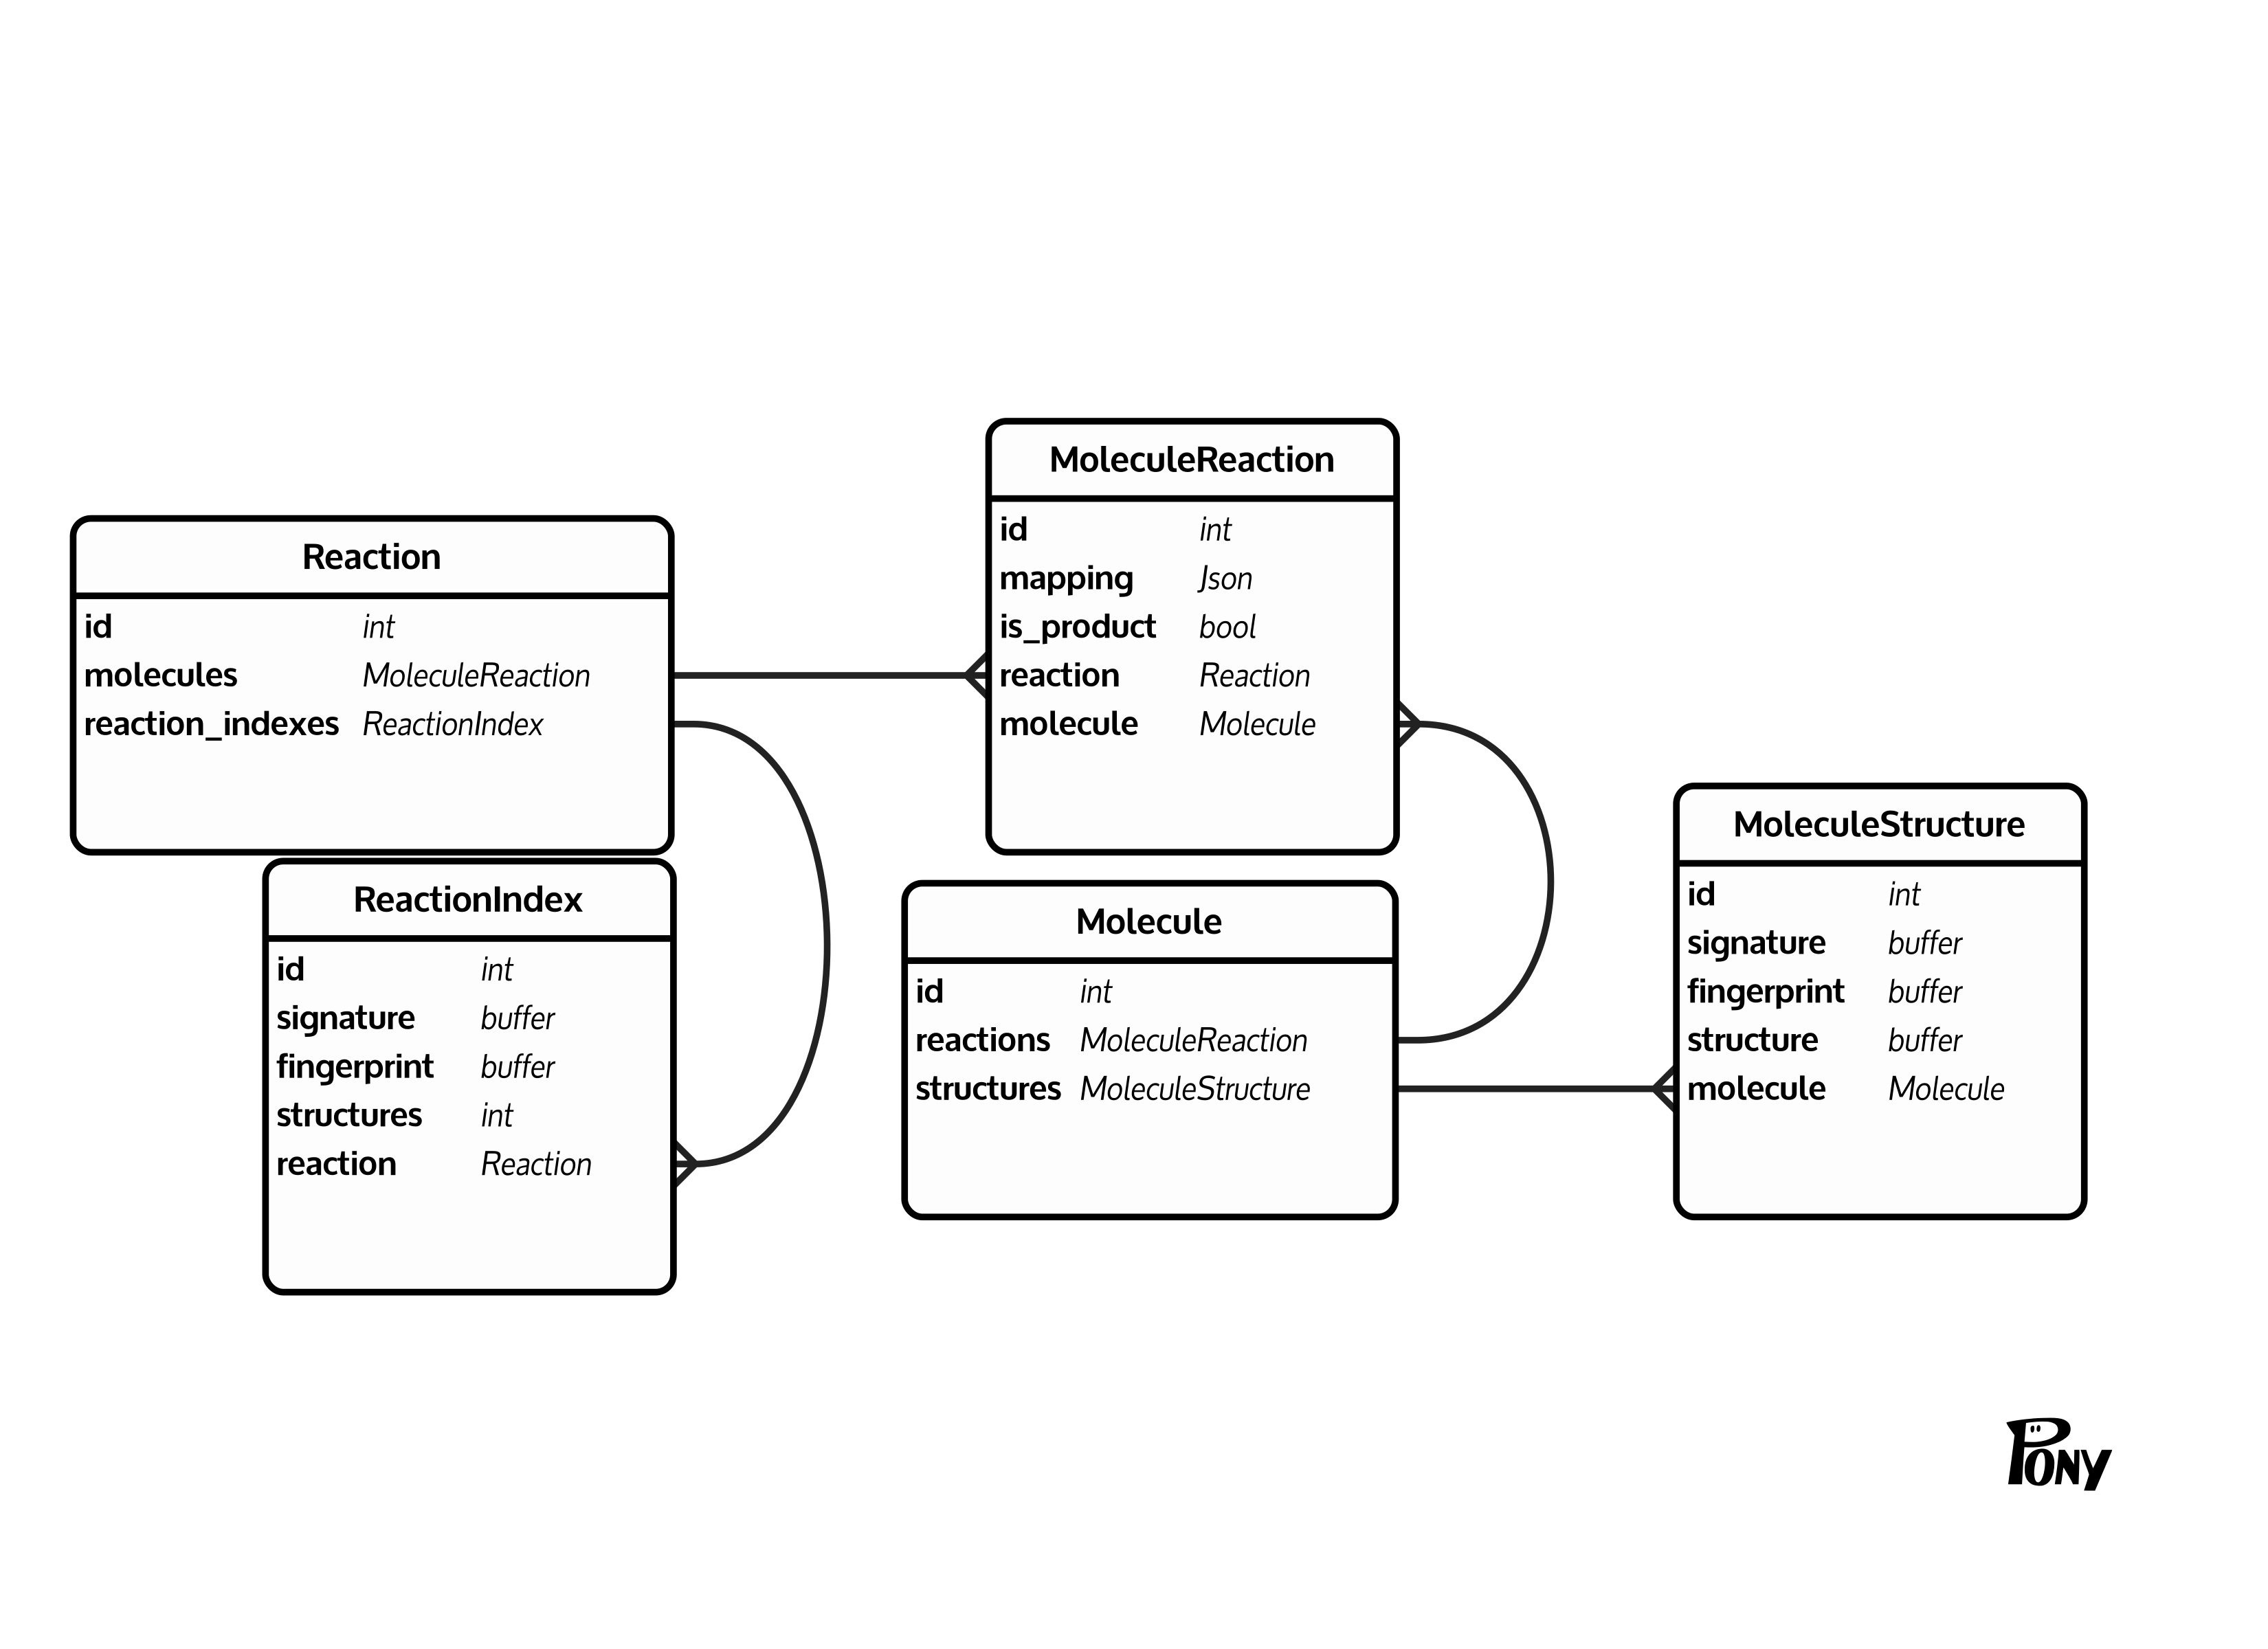

In [4]:
# define paramerets of the DB for fingerprinting and LSH algorithm
# linear fragments are used for the fingerprints, such paramereters as length of the fragment,
# length of fingerprint, number of active bits and bit pairs for the fragment can be modified.
# Additionally, hydrogens can included in fragments.
from pony.orm import db_session
from CGRdb.database.config import Config
with db_session():
    db.execute("Create extension if not exists intarray;")
    Config(key="fingerprint",value={"min_radius":1, "max_radius":4, "length":2048,
                 "number_active_bits":2, "number_bit_pairs":4})
    Config(key="lsh_num_permute",value=64)
    Config(key="lsh_threshold",value=0.7)

# Data storing

Load example reaction and molecule

In [2]:
# read one smiles from zip file and constract CGRtools.MoleculeContainer
import zipfile
from CGRtools import smiles
file = zipfile.ZipFile("../dataset/Chembl28.smi.zip")
line = next(file.open("Chembl28.smi")).decode().split()
if len(line) >= 3 and line[1].startswith("|"):
    mol = smiles("".join([line[0],line[1]]))
else:
    mol = smiles(line[0])

In [3]:
mol.clean2d() # generate coordinates for graph, to make it visualizable
mol

In [4]:
# read one smiles from zip file and constract CGRtools.MoleculeContainer
import zipfile
from CGRtools import smiles
file = zipfile.ZipFile("../dataset/USPTO.smi.zip")
line = next(file.open("USPTO.smi")).decode().split()
if len(line) >= 3 and line[1].startswith("|"):
    reaction = smiles("".join([line[0],line[1]]))
else:
    reaction = smiles(line[0])

In [5]:
reaction.clean2d() # generate coordinates for graph, to make it visualizable
reaction

## Direct storage of molecules
Only new molecules can be stored in DB. Already exists molecules will raise exception.

In [9]:
with db_session():
    m = Molecule(mol)
    idx = m.id
    m  # molecule record object

# MoleculeStructure object was automatically created for this molecule
# and became canonic_structure for this Molecule. Later user can introduce additional structures
# for the representation of the same Molecule (for example Tautomer)

In [10]:
# Relation to the canonic structure
with db_session():
    m = Molecule.get(mol) # get DB object by structure
    can_structure = m.canonic_structure
can_structure

MoleculeStructure[1]

In [11]:
# lookup for the whole list of structures that corresponds to this molecule
with db_session():
    m = Molecule.get(mol) # get DB object by structure
    structures = list(m.structures)
structures

[MoleculeStructure[1]]

In [12]:
# take CGRtools.MolecularContainer object from DB
with db_session():
    m = Molecule.get(mol) 
    structure = m.canonic_structure.structure
structure

In [13]:
# alternative way of accessing the structures
with db_session():
    m = Molecule.get(mol) 
    structure = list(m.structures)[0].structure 
structure
# structure is a CGRtools.Molecule container and provide all method of the Class

In [14]:
# fingerprint of the Molecular Structure can be accessed as well as SMILES 
# (if user do not access the graph based representaion of molecule)
with db_session():
    m = Molecule.get(mol) 
    fp = m.canonic_structure.fingerprint
fp

[1,
 2,
 3,
 514,
 1541,
 517,
 1031,
 6,
 1033,
 9,
 1035,
 521,
 1037,
 526,
 527,
 1039,
 1553,
 538,
 1563,
 540,
 1573,
 1064,
 1065,
 43,
 46,
 1070,
 558,
 52,
 1589,
 54,
 1537,
 1594,
 62,
 576,
 577,
 67,
 82,
 1619,
 595,
 1113,
 1120,
 1121,
 1633,
 96,
 102,
 615,
 1133,
 110,
 621,
 118,
 1656,
 125,
 1155,
 643,
 1161,
 1163,
 1677,
 1169,
 659,
 1173,
 1688,
 1177,
 154,
 157,
 1697,
 1699,
 679,
 170,
 1707,
 1708,
 1710,
 689,
 692,
 186,
 1725,
 1217,
 716,
 1740,
 1229,
 210,
 1234,
 727,
 1756,
 224,
 1760,
 738,
 743,
 1767,
 744,
 238,
 1280,
 769,
 1800,
 1291,
 1803,
 269,
 277,
 1815,
 1836,
 301,
 1329,
 1336,
 314,
 1851,
 1854,
 319,
 329,
 1358,
 340,
 348,
 1884,
 865,
 866,
 868,
 357,
 360,
 873,
 879,
 882,
 1396,
 1923,
 1416,
 909,
 1934,
 911,
 1935,
 1937,
 1427,
 1941,
 411,
 924,
 414,
 1958,
 936,
 1449,
 938,
 942,
 1458,
 1974,
 1472,
 1984,
 448,
 1473,
 1991,
 461,
 1485,
 463,
 1997,
 2003,
 1492,
 477,
 990,
 1515,
 492,
 2035,
 2040,
 204

In [15]:
with db_session():
    m = Molecule.get(mol) 
    sm = m.canonic_structure.smiles
sm

'C([C@@H](O)[C@H]([C@H]1[C@H](NC(=O)C)[C@@H](O)[C@H]([C@](F)(C(=O)O)O1)F)O)O'

In [16]:
# Also reverse relation can be seen
with db_session():
    m = Molecule.get(mol) 
    moldb = m.canonic_structure.molecule
moldb

Molecule[1]

## Storing of Substances as more safe way for storage of chemical data
Substance do not have to be Unique, as it represents real jar with compound, with its manufacturer, expiration data, barcode etc. As an example we will give numbers as a name for the Substance. This was done, because Substance can include one or several molecules and user have posibility store them as an entity itself.

In [6]:
hexane = smiles("C1CCCCC1")
hexane.clean2d()
hexane

In [7]:
y = mol.union(hexane, remap=True)

In [8]:
y.clean2d()
y

In [9]:
mol, hexane = y.split()

In [31]:
# Substance take list of tuples of molecules with their percentage in the compound.
# If there is no information about ratio, None can be used.
# for example we will add some n-hexane solvent and store the solution of previous molecule
subs = [(mol, 0.2),(hexane,0.8)]
with db_session():
    s = Substance(subs, name="AA000001")
    idx = s.id
s

Substance[1]

In [32]:
s.name

'AA000001'

In [33]:
# accessing the stucture of substance
with db_session():
    s = Substance[idx]
    s_struct = s.structure
s_struct.clean2d()
s_struct

In [34]:
with db_session():
    s = Substance[idx]
    component1, component2 = s.components # components are either Molecules or NonOrganics

In [35]:
print(f"""
molar_fraction of 1st mol, {component1.molar_fraction}
molar_fraction of 2nd mol, {component2.molar_fraction}
      """)


molar_fraction of 1st mol, 0.2
molar_fraction of 2nd mol, 0.8
      


In [36]:
# get individual structures of components
with db_session():
    s = Substance[idx]
    component1, component2 = s.components
    structure1 = component1.structure
    structure2 = component2.structure

In [37]:
structure1

In [38]:
structure2

## Reaction storage
Each reaction considered as and individual experiment, so duplicates are possible

In [39]:
reaction

In [40]:
# store reaction without CGR structure 
with db_session:
    r = Reaction(reaction)
    idx = r.id
r  # reaction record object

Reaction[1]

In [41]:
# check the structure of reaction
with db_session:
    r = Reaction[idx]
    r_structure = r.structure
r_structure

In [42]:
# check the substances of reaction
with db_session:
    r = Reaction[1]
    substances = list(r.substances)
substances

[ReactionSubstance[1], ReactionSubstance[3], ReactionSubstance[2]]

In [43]:
# check the structure of any substance from reaction
with db_session:
    r = Reaction[1]
    substances = list(r.substances)
    str1 = substances[0].structure
str1

In [44]:
# store reaction with CGR structure
with db_session:
    r = Reaction(reaction, keep_cgr=True)
r  # reaction record object

Reaction[2]

In [45]:
# check the structure of CGR
with db_session:
    r = Reaction[2]
    str2 = r.CGR.structure
str2.clean2d()
str2

# Getting data from DB

Cartridge based on Pony ORM https://ponyorm.com.

The main concepts of interaction with DB are preserved

# Molecules Searching
All searches are based on Molecules and their MoleculeStructure entities, the following search cases supported:
* exact molecule - return molecule that corresponds to provided structure
* substructure search - return python generator with Molecules that are superstructures for the query structure
* similar molecules - return python generator with Molecules that are similar to query structure


## please upload data from Chembl28 to proceed
You can upload part of the dataset, to save time and resourses, but take into account that it also affects on results of searches.

### Substructure search of molecules

In [3]:
from CGRdb.tests import mol_queries
from CGRtools import smiles

In [4]:
query = smiles(list(mol_queries.values())[0])

In [5]:
query.clean2d()
query

In [8]:
res = Molecule.substructres(query) # difficult query for db, please use more precise query for faster responses
# response in a generator object
# by default substructures method used with ordered=True option, so it will return all substructures ordered by similarity,
# if user do not want to do that, ordered=False othion should be used. It will increase speed of the first
# reponse.
# request_only option is for internal usage or debugging to see actual sql request
# last option tanimoto_limit=None, takes tanimoto limit from config table of DB, can be override, to go for
# lower similarities, that we do not reccomend. This could lead to erronious iterpretatioin that request 
# will give ALL other molecules from DB, but in fact it will give only rest of the molecules from the buckets 
# of LSH algorithm. So in order to go for lower similarities reconfigure DB and re-index it 
# with new similarity limit

In [103]:
a = next(res) # result is Molecule obj, MoleculeStructure obj that contain query and Tanimoto score

In [104]:
a[1].structure.clean2d() # taking structure through MoleculeStructure obj
a[1].structure

In [105]:
a[0].canonic_structure.structure.clean2d() # taking structure through canonic_structure(main) of Molecule obj
a[0].canonic_structure.structure

In [106]:
# Tanimoto
a[2]

0.6619718309859155

### Similarity search of molecules
Searching of molecules with similar by tanimoto structures. By default molecules is similar if tanimoto index greater than `0.7`.

In [108]:
res = Molecule.similars(query)  # MoleculeSearchCache object or None returned
# response in a generator object
# by default substructures method used with ordered=True option, so it will return all similar ordered by similarity,
# if user do not want to do that, ordered=False othion should be used. It will increase speed of the first
# reponse.
# request_only option is for internal usage or debugging& to see actual sql request

In [109]:
a = next(res)
a

In [111]:
a[1].structure.clean2d() # taking structure through MoleculeStructure obj
a[1].structure

In [112]:
a[0].canonic_structure.structure.clean2d() # taking structure through canonic_structure(main) of Molecule obj
a[0].canonic_structure.structure

In [113]:
# Tanimoto
a[2]

1.0

## Searching of reaction by one molecule
* search molecules by similarity and return reactions with that molecules
* search molecules by substructure and return reactions with that molecules

In [114]:
from CGRdb.tests import mol_queries
from CGRtools import smiles

In [116]:
res = Molecule.substructures_in_reactions(query) 
# search molecules by substructure and return reactions with that molecules

In [123]:
a = next(res)

In [124]:
a

(Reaction[529325], Molecule[662024], 0.1525974025974026)

In [125]:
a[0].structure.clean2d() # taking structure through MoleculeStructure obj
a[0].structure

In [126]:
a[1].canonic_structure.structure.clean2d()
a[1].canonic_structure.structure

In [127]:
res = Molecule.similars_in_reactions(query) 
# search molecules by similarity and return reactions with that molecules

In [128]:
a = next(res)

In [129]:
a

(Reaction[224], Molecule[471], 0.7121212121212122)

In [130]:
a[0].structure.clean2d() # taking structure through Reaction obj
a[0].structure

In [131]:
a[1].canonic_structure.structure.clean2d()
a[1].canonic_structure.structure

In [140]:
# Tanimoto
a[2]

3.0

## Searching of Reaction by all components
Possible next types of reactions searching:
* reactions by all molecules according to their role in reaction:
    * by substructure of molecules
        * with reaction center control (reqires atom-to-atom mapping for query reaction and stored in DB)
        * without reaction center control (default)
    * by similarity molecules
        * with reaction center control (reqires atom-to-atom mapping for query reaction and stored in DB)
        * without reaction center control (default)

In [4]:
from CGRdb.tests import reaction_queries
from CGRtools import smiles

In [5]:
query = smiles(list(reaction_queries.values())[0])

In [143]:
query.clean2d()
query

In [135]:
# return reactions by summary similarity of the components (with option ordered=True)
res = Reaction.similars(query,ordered=True, fix_roles=True,
                 mapping=False, request_only=False)
# fix_roles responsible for roles matching in query and result reaction, if False - results can contain results
# of search with mismatched roles (e.g product molecule within reactants)
# mapping option turn on the control of reaction center (only for reactions that were stored with mapping,
# query should also contain mapping)
# request_only - for debugging and internal useage of DB, returns actual SQL request

In [136]:
a = next(res) # returns Reaction obj, list of Molecules that matched query and summary Tanimoto
a

(Reaction[5303], [Molecule[2065], Molecule[8804], Molecule[8795]], 3.0)

In [137]:
a[0].structure.clean2d() # taking structure through Reaction obj
a[0].structure

In [139]:
a[1][0].canonic_structure.structure.clean2d() # taking structure through Molecule obj
a[1][0].canonic_structure.structure

In [141]:
# Tanimoto
a[2]

3.0

In [6]:
# The same as previous request, but with control of reaction center
res = Reaction.similars(query,ordered=True, fix_roles=True,
                 mapping=True, request_only=False) 

In [7]:
a = next(res) # returns Reaction obj, list of Molecules that matched query and summary Tanimoto
a

(Reaction[5303], [Molecule[2065], Molecule[8804], Molecule[8795]], 3.0)

In [8]:
a[0].structure.clean2d() # taking structure through Reaction obj
a[0].structure

In [9]:
a[1][0].canonic_structure.structure.clean2d() # taking structure through Molecule obj
a[1][0].canonic_structure.structure

## Searching of Reactions by Condensed Graph of Reaction (CGR)
* Possible next types of reactions searching:
    * by substructure of CGR
    * by similarity of CGR

In [19]:
from CGRdb.tests import cgr_queries
from CGRdb.database import CGR

In [20]:
query = smiles(list(cgr_queries.values())[0])

In [21]:
query.clean2d()
query

In [34]:
res = CGR.similars(query) 
# same options that available for Molecule.similars
# also can be applied here (ordered, request_only)

In [35]:
a = next(res) # returns CGR that matched query and summary Tanimoto
a

(CGR[4043], 1.0)

In [36]:
a[0].structure.clean2d()
a[0].structure

In [37]:
# Tanimoto
a[1]

1.0

In [38]:
res = CGR.substructres(query)
# same options that available for Molecule.substructures
# also can be applied here (ordered, request_only)

In [50]:
a = next(res) # returns CGR that matched query and summary Tanimoto
a

StopIteration: 

In [51]:
a[0].structure.clean2d()
a[0].structure

In [49]:
# Tanimoto
a[1]

0.6854460093896714